## Tutorial 4: off-line learning the Q-values of the Kennedy receiver ##

In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random


def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn

def ps_maxlik(beta):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    p=0
    for n1 in [0,1]:
       p+=Prob(np.sign(beta)*(-1)**(n1)*alpha, beta, n1)
    return p/2


### what we wanna learn ###

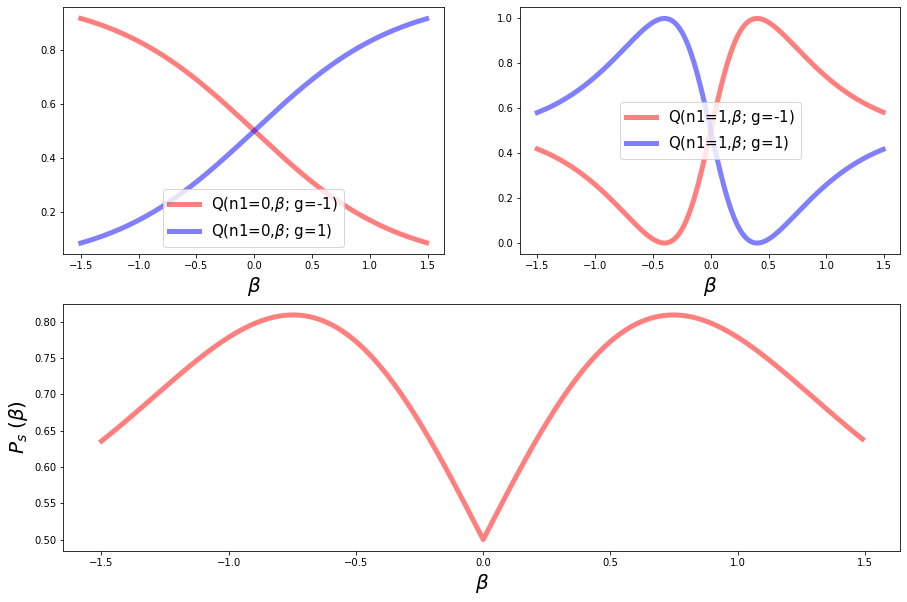

In [4]:


plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((2,2),(0,0))
ax2 =  plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0),colspan=2)

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

betas = np.arange(-1.5,1.5,.01)
ax3.plot(betas,[ps_maxlik(b) for b in betas],alpha=0.5,c="red", linewidth=5)
ax3.set_xlabel(r'$\beta$', size=20)
ax3.set_ylabel(r'$P_s\; ( \beta )$', size=20)

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


### So we create the dataset, notice now we return almost pre-processed ###

In [5]:
class DataSet():
    def __init__(self, size=10**3, nbetas=10,rpbgo=-1):
        #rpbgo = rewards per beta-guess-outcome
        self.size = size
        self.amplitude = 0.4
        self.betas = np.linspace(-1.5, 1.5,nbetas)
        self.rpbgo = rpbgo
        if self.rpbgo!=-1:
            self.size = 4*nbetas*rpbgo
        #d = {"a0":[], "h1-a1":[], "r2":[]}
        d=[]
        #for episode in range(size):
        for b in self.betas:
            for outcome in [0.,1,]:
                for guess in [-1.,1.]:
                    for k in range(self.rpbgo):
                        mean_bernoulli = qval(b, outcome, guess)
                        reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
                        d.append([b, outcome, guess, reward])
    #for beta in self.betas:
     #      #beta = np.random.choice(self.betas,1)[0]
      #      for repetitions in range(int(self.size/len(self.betas))):
       #         proboutcome = Prob(self.amplitude,beta,0)
        #        outcome = np.random.choice([0.,1.],1,p=[proboutcome, 1-proboutcome])[0]
         #       guess = np.random.choice([-1,1],1)[0]
          #      mean_bernoulli = qval(beta, outcome, guess)
           #     reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
#
 #               d.append([beta,outcome,guess,reward])
            #d["a0"].append([beta])
            #d["h1-a1"].append([beta, outcome, guess])
            #d["r2"].append(reward)
        self.data_unsplitted=np.array(d)
        #self.data_unsplitted = {}
        #for k in d.keys():
         #   self.data_unsplitted[k] = np.array(d[k])
    def sample_minibatch(self, bs):
        #samples a minibatch of full history of transitions: a0 -> h0 -> a1 -> h1 -> r2.
        #returns a random sample of {a0}, {h1-a1}, {r2} ordered!
        d = self.data_unsplitted[np.random.choice(np.arange(self.size),int(bs),replace=False)]
        a0s = d[:,0]
        h0s_a1s = d[:,[0,1,2]]
        r2s = d[:,3]
        return a0s, h0s_a1s, r2s
    
    def pre_process(self, data):
        data_prep = []
        for ind, d in enumerate(data):
            a0s = d[:,0]
            h0s_a1s = d[:,[0,1,2]]
            r2s = d[:,3]
            data_prep.append([a0s, h0s_a1s, r2s])
        return data_prep
    
    
    def give_epoch(self, bs):
        #gives a list of batches that form an epoch
        epoch=[]
        data = self.data_unsplitted.copy()
        np.random.shuffle(data)
        data = self.BatchSizeSplit(data, bs)[0]
        data = self.pre_process(data)
        return data
        #for k in range(int(self.siz|e/bs)):
         #   epoch.append(self.sample_minibatch(bs))
        #return epoch
    
    def BatchSizeSplit(self, dataset,batch_size):
        
        splits = int(len(dataset)/batch_size)
        if len(dataset)%batch_size !=0:
            #print("Not divisible!: breaking into len(dataset)%batch_size")
            splits = int(len(dataset)/batch_size)
            sobra = int(len(dataset)%batch_size)
            splited = np.split(dataset[sobra:], splits + len(dataset[sobra:])%splits)
            return splited, len(splited[0])
        else:
            splited = np.split(dataset, splits + len(dataset)%splits)
            return splited, len(splited[0])


### Let's see if things are done well.. ###

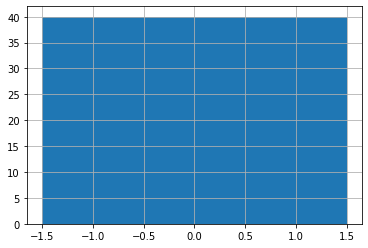

In [6]:
dataset = DataSet(10**3, rpbgo=10)
betas_done = pd.Series(dataset.data_unsplitted[:,0])
betas_done.hist()

In [7]:
epoch = dataset.give_epoch(10)
print("How many batches in epoch?: {}".format(len(epoch)))
print("How big is a batch? how many betas we put per batch? {}".format(len(epoch[0][0])))


How many batches in epoch?: 40
How big is a batch? how many betas we put per batch? 10


In [8]:
epoch = dataset.give_epoch(100)
print("How many batches in epoch?: {}".format(len(epoch)))
print("How big is a batch? how many betas we put per batch? {}".format(len(epoch[0][0])))


How many batches in epoch?: 4
How big is a batch? how many betas we put per batch? 100


In [9]:
epoch = dataset.give_epoch(30)
print("How many batches in epoch?: {}".format(len(epoch)))
print("How big is a batch? how many betas we put per batch? {}".format(len(epoch[0][0])))


How many batches in epoch?: 13
How big is a batch? how many betas we put per batch? 30


### Define the networks ###

In [10]:

class Net(tf.keras.Model):
    #input_dim: 1 if layer=0, 3 if layer= 2, for the Kennedy receiver ##
    def __init__(self, input_dim, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(input_dim,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
#        feat = tf.nn.dropout(feat, rate=0.01)
 #       feat = tf.nn.relu(self.l2(feat))
  #      feat = tf.nn.dropout(feat, rate=0.01)
   #     feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


In [15]:
## now let's define the training loop ##

In [ ]:
data

In [ ]:
net_1 = Net()

In [11]:
def calculate_greedy_from_batch(net_1, batch):
    ##### TIS FUNCTION NEED TO BE OPTIMIZED"!!!
    st = datetime.now()
    labels_net0=[]
    for k in batch[1][:,[0,1]]:
        q_s_all_actions=[]

        for guess in [-1.,1.]:
            gg=[]
            gg = np.append(gg, np.append(k,guess))
            q_s_all_actions.append([gg])
        labels_net0.append(np.max(np.squeeze(net_1(np.array(q_s_all_actions)))))
    print(datetime.now()-st)
    return np.expand_dims(labels_net0,axis=1)

### this function may be crazy, but it's just to plot the predictions of the second network ##

In [12]:
def plot_predictions(histo_preds, losses, betas, title=None):

    plt.figure(figsize=(25,20))
    ax1 =  plt.subplot2grid((2,3),(0,0))
    ax2 =  plt.subplot2grid((2,3),(0,1))
    ax3 = plt.subplot2grid((2,3),(1,0), colspan=2)
    ax4 = plt.subplot2grid((2,3),(0,2))
    ax5 = plt.subplot2grid((2,3),(1,2))

    ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,[ps_maxlik(b) for b in betas],alpha=0.5,c="red", linewidth=5)
    ax3.set_xlabel(r'$\beta$', size=20)
    ax3.set_ylabel(r'$P_s\; ( \beta )$', size=20)

    betas_train = betas
    for predictions in histo_preds["net_1"].values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.25, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.25, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.25,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.25,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

    
    ### we do the same for ax3:
    
    for predictions in histo_preds["net_0"].values():
        ax3.plot(betas_train,predictions["values"],alpha=0.25, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")

    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")


    for ax in [ax1, ax2,ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        #ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
        
     #### not plot the losses"####   
    for ax, loss in zip([ax4,ax5],losses):
        ax.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax.scatter(np.arange(1,len(loss)+1),loss,s=150,alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

        ax.set_xlabel("epoch", size=20)
        ax.set_ylabel("Loss",size=20)
    return

In [13]:
def supervised_training_last(batch_size=32., total_epochs=30, buffer_size=10**4):

    net_0 = Net(input_dim=1)
    net_1 = Net(input_dim=3)

    net_0(np.array([[0.],[1.]])) #initialize the network 0, arbitrary inputs.
    net_1(np.array([[0.,1.,1.]]))

    optimizer_0 = tf.keras.optimizers.Adam(lr=0.001/2.)
    optimizer_1 = tf.keras.optimizers.Adam(lr=0.001/2.)

    dataset = DataSet(rpbgo=100, nbetas=20)
    histo_preds = {"net_0":{}, "net_1":{}} #here i save the predictions

    loss_0_ev, loss_1_ev = [], []
    for epoch_number in tqdm(range(total_epochs)):
        epoch = dataset.give_epoch(batch_size)
        loss_0_avg, loss_1_avg = [], []

        for batch in epoch:

            #labels_net0 = calculate_greedy_from_batch(net_1, batch )
            labels_net1 = np.expand_dims(batch[2],axis=1)
            loss_0=0
            with tf.GradientTape() as tape:
                tape.watch(net_1.trainable_variables)
                preds1 = net_1(batch[1])
                loss_1 = tf.keras.losses.MSE(labels_net1,preds1)
                loss_1 = tf.reduce_mean(loss_1)
                grads1 = tape.gradient(loss_1, net_1.trainable_variables)
                optimizer_1.apply_gradients(zip(grads1, net_1.trainable_variables))
            loss_0_avg.append(loss_0)
            loss_1_avg.append(loss_1)

        ### save the average losses per epoch###
        mean_loss_0 = np.mean(loss_0_avg)
        mean_loss_1 = np.mean(loss_1_avg)
        loss_0_ev.append(mean_loss_0)
        loss_1_ev.append(mean_loss_1)

        ### save the network's prediction at each epoch ###
        for nett in ["net_0","net_1"]:

            histo_preds[nett][str(epoch_number)] ={} 
            histo_preds[nett][str(epoch_number)]["epoch_number"] = epoch_number
            histo_preds[nett][str(epoch_number)]["values"] = {}

        histo_preds["net_0"][str(epoch_number)]["values"] = np.squeeze(net_0(np.expand_dims(dataset.betas,axis=1)))

        index=0
        for n1 in [0.,1.]:
            for guess in [-1.,1.]:
                foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                histo_preds["net_1"][str(epoch_number)]["values"][str(index)] = np.squeeze(net_1(foo))
                index+=1
        if epoch%max(1,int(total_epocs/10)) ==0:
            print("#### \nepoch: {}\nloss_0: {}\nloss_1: {}\n \n***********\n".format(epoch_number,mean_loss_0,mean_loss_1))
    losses = [loss_0_ev, loss_1_ev]
    return histo_preds, losses, dataset.betas

In [14]:
histo_preds, losses, betas = supervised_training_last(batch_size=500, total_epochs=100, buffer_size=10**4)

#### 
epoch: 0
loss_0: 0.0
loss_1: 0.24964660154463275
 
***********

#### 
epoch: 1
loss_0: 0.0
loss_1: 0.24915157691325368
 
***********

#### 
epoch: 2
loss_0: 0.0
loss_1: 0.2484630811324948
 
***********

#### 
epoch: 3
loss_0: 0.0
loss_1: 0.2473838499305024
 
***********

#### 
epoch: 4
loss_0: 0.0
loss_1: 0.24574066118838866
 
***********

#### 
epoch: 5
loss_0: 0.0
loss_1: 0.24342362533709966
 
***********

#### 
epoch: 6
loss_0: 0.0
loss_1: 0.2402388179183915
 
***********

#### 
epoch: 7
loss_0: 0.0
loss_1: 0.23617906654492732
 
***********

#### 
epoch: 8
loss_0: 0.0
loss_1: 0.23132042054354085
 
***********

#### 
epoch: 9
loss_0: 0.0
loss_1: 0.22590512025041903
 
***********

#### 
epoch: 10
loss_0: 0.0
loss_1: 0.21998214431422944
 
***********

#### 
epoch: 11
loss_0: 0.0
loss_1: 0.21393654965919204
 
***********

#### 
epoch: 12
loss_0: 0.0
loss_1: 0.2080752038759213
 
***********

#### 
epoch: 13
loss_0: 0.0
loss_1: 0.20261005752885936
 
***********

#### 
epoch: 14
loss

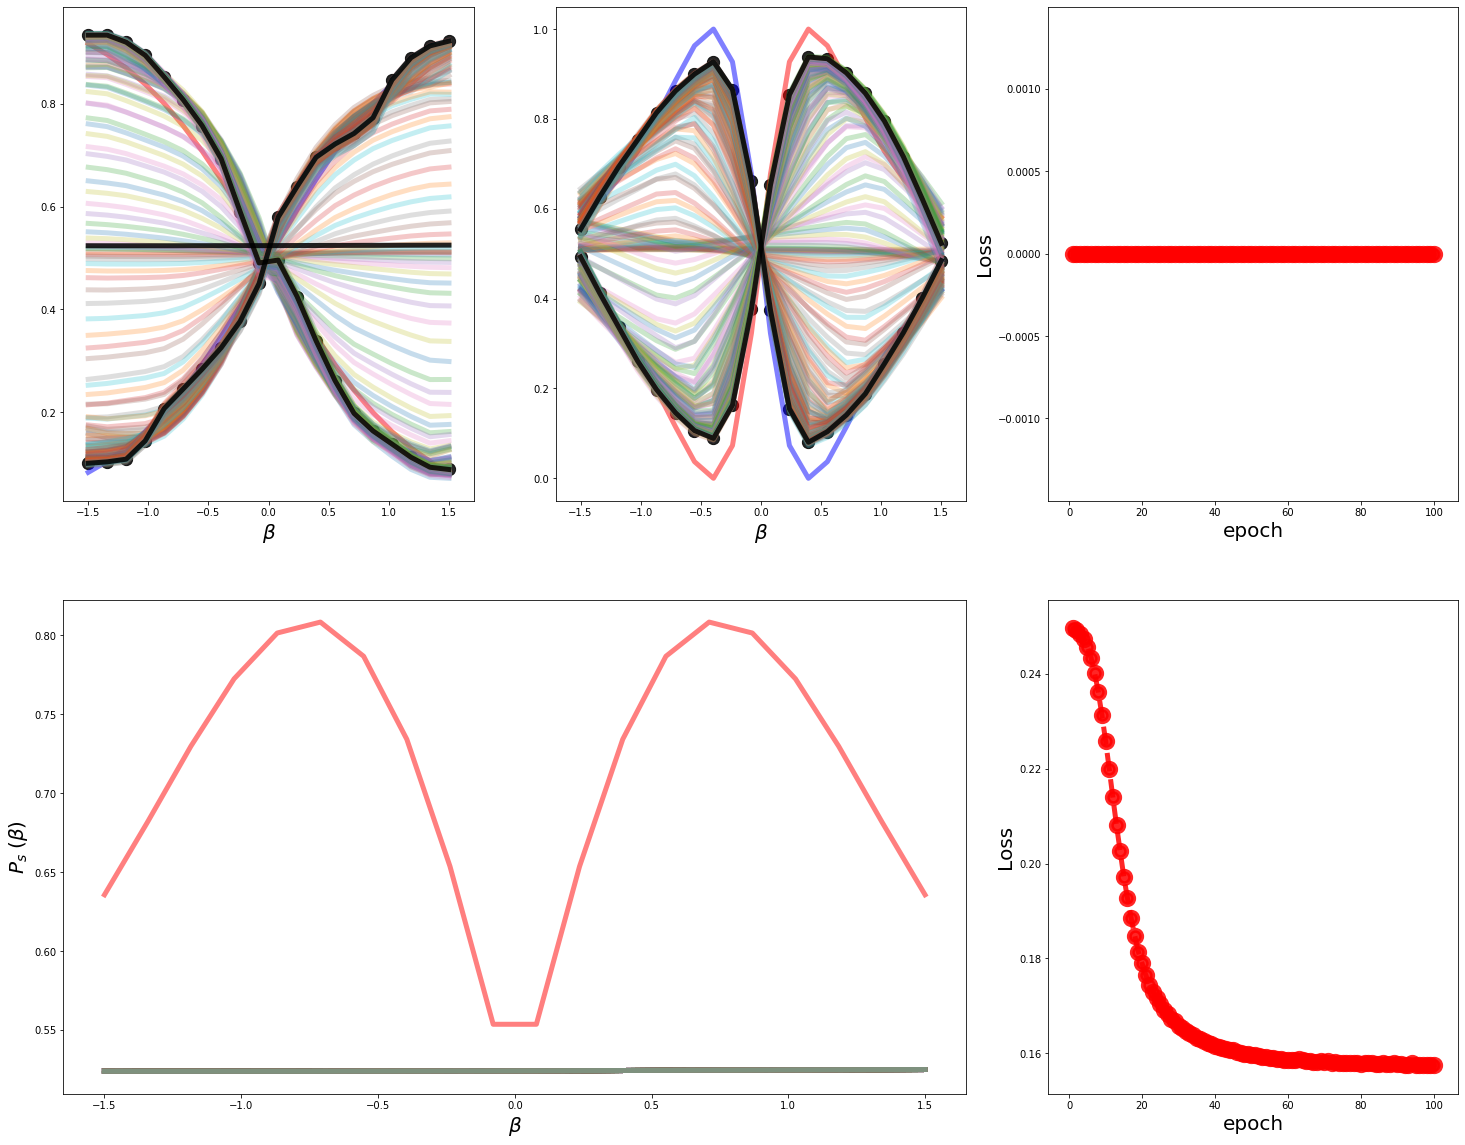

In [15]:
plot_predictions(histo_preds,losses,betas)

0:00:01.751341
0:00:01.744397
0:00:01.740011
0:00:01.724534
0:00:01.816891
0:00:01.720638
0:00:01.777690
0:00:01.963403
0:00:01.734183
0:00:01.730877
0:00:01.743075
0:00:01.760843
0:00:01.752381
0:00:01.748713
0:00:01.730305
0:00:01.741753
#### 
epoch: 0
loss_0: 0.0018186635618718796
loss_1: 0.25054160269621173
 
***********



0:00:01.729054
0:00:01.749071
0:00:01.768337
0:00:01.704839
0:00:01.763214
0:00:01.754207
0:00:01.751066
0:00:01.775379
0:00:01.705770
0:00:01.787966
0:00:01.870371
0:00:01.816693
0:00:01.832846
0:00:02.118043
0:00:02.002700
0:00:01.783367
#### 
epoch: 1
loss_0: 0.0006843888091522368
loss_1: 0.249875705273965
 
***********



0:00:01.825835
0:00:01.834270
0:00:01.905553
0:00:01.993006
0:00:02.115001
0:00:01.892049
0:00:02.042943
0:00:02.078987
0:00:01.812137
0:00:01.753194
0:00:01.762741
0:00:01.846696


KeyboardInterrupt: 

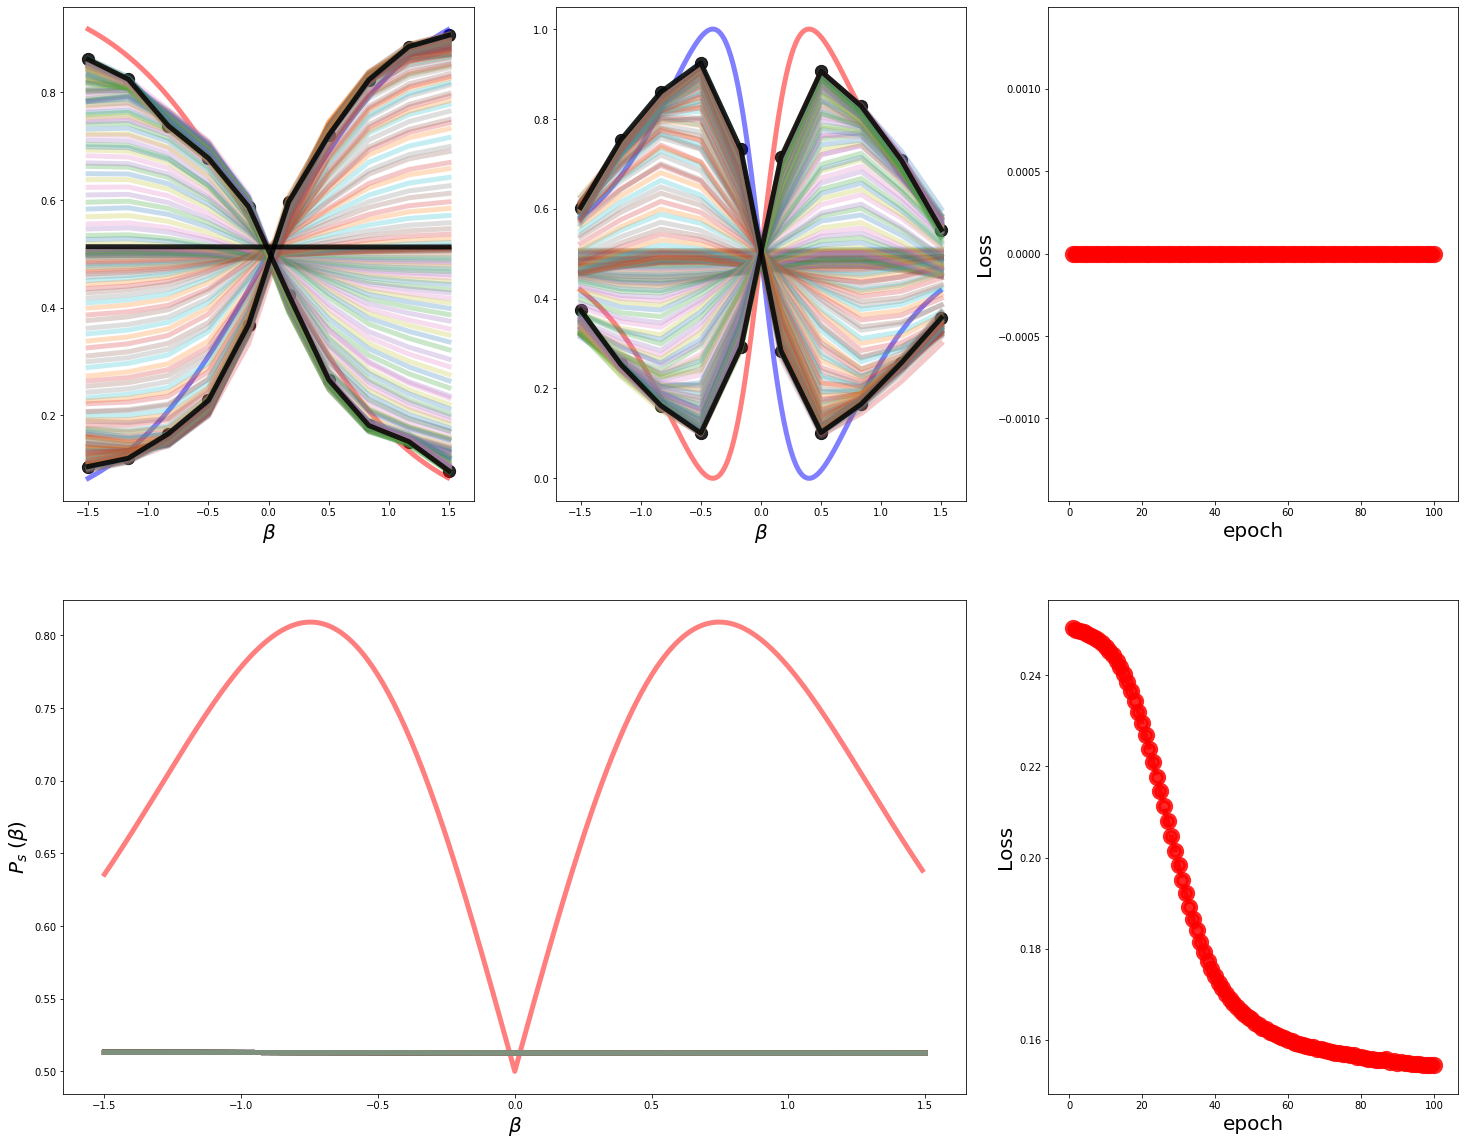

In [112]:
plot_predictions(histo_preds, losses)

In [ ]:
def supervised_training_both(batch_size=32., total_epochs=30, buffer_size=10**4):

    net_0 = Net(input_dim=1)
    net_1 = Net(input_dim=3)

    net_0(np.array([[0.],[1.]])) #initialize the network 0, arbitrary inputs.
    net_1(np.array([[0.,1.,1.]]))

    optimizer_0 = tf.keras.optimizers.Adam(lr=0.001/2.)
    optimizer_1 = tf.keras.optimizers.Adam(lr=0.001/2.)

    dataset = DataSet(rpbgo=100, nbetas=20)
    histo_preds = {"net_0":{}, "net_1":{}} #here i save the predictions

    loss_0_ev, loss_1_ev = [], []
    for epoch_number in tqdm(range(total_epochs)):
        epoch = dataset.give_epoch(batch_size)
        loss_0_avg, loss_1_avg = [], []

        for batch in tqdm(epoch):

            labels_net0 = calculate_greedy_from_batch(net_1, batch )
            labels_net1 = np.expand_dims(batch[2],axis=1)
            with tf.GradientTape() as tape:
                tape.watch(net_0.trainable_variables)
                preds0 = net_0(np.expand_dims(batch[0],axis=1))
                loss_0 = tf.keras.losses.MSE(labels_net0,preds0)
                loss_0 = tf.reduce_mean(loss_0)
                grads0 = tape.gradient(loss_0, net_0.trainable_variables)
                optimizer_0.apply_gradients(zip(grads0, net_0.trainable_variables))
            with tf.GradientTape() as tape:
                tape.watch(net_1.trainable_variables)
                preds1 = net_1(batch[1])
                loss_1 = tf.keras.losses.MSE(labels_net1,preds1)
                loss_1 = tf.reduce_mean(loss_1)
                grads1 = tape.gradient(loss_1, net_1.trainable_variables)
                optimizer_1.apply_gradients(zip(grads1, net_1.trainable_variables))
            loss_0_avg.append(loss_0)
            loss_1_avg.append(loss_1)

        ### save the average losses per epoch###
        mean_loss_0 = np.mean(loss_0_avg)
        mean_loss_1 = np.mean(loss_1_avg)
        loss_0_ev.append(mean_loss_0)
        loss_1_ev.append(mean_loss_1)

        ### save the network's prediction at each epoch ###
        for nett in ["net_0","net_1"]:

            histo_preds[nett][str(epoch_number)] ={} 
            histo_preds[nett][str(epoch_number)]["epoch_number"] = epoch_number
            histo_preds[nett][str(epoch_number)]["values"] = {}

        histo_preds["net_0"][str(epoch_number)]["values"] = np.squeeze(net_0(np.expand_dims(dataset.betas,axis=1)))

        index=0
        for n1 in [0.,1.]:
            for guess in [-1.,1.]:
                foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                histo_preds["net_1"][str(epoch_number)]["values"][str(index)] = np.squeeze(net_1(foo))
                index+=1

        print("#### \nepoch: {}\nloss_0: {}\nloss_1: {}\n \n***********\n".format(epoch_number,mean_loss_0,mean_loss_1))
    losses = [loss_0_ev, loss_1_ev]
    return histo_preds, losses